In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import math
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from scipy.stats import ttest_ind, skew, kurtosis, shapiro
from datetime import datetime
from pandas.api.types import CategoricalDtype

In [2]:
df = pd.read_csv("TrialMonitoringData.csv", encoding = 'ISO-8859-1', parse_dates=[0], dayfirst=True)

In [3]:
df['Date and Time of capture'] = pd.to_datetime(df['Date and Time of capture'], format='%d/%m/%Y %H:%M:%S')

In [4]:
df['Date and Time of capture'].min()

Timestamp('2011-09-01 00:00:00')

In [5]:
df['Date and Time of capture'].max()

Timestamp('2012-08-30 23:30:00')

In [6]:
df.head(10)

,Location ID,Measurement Description,Parameter Type and Units,Date and Time of capture,Parameter
0,100600,Electricity supply meter,Consumption in period [kWh],2012-03-01 00:00:00,0.893
1,100600,Electricity supply meter,Consumption in period [kWh],2012-03-01 00:30:00,0.824
2,100600,Electricity supply meter,Consumption in period [kWh],2012-03-01 01:00:00,0.795
3,100600,Electricity supply meter,Consumption in period [kWh],2012-03-01 01:30:00,0.847
4,100600,Electricity supply meter,Consumption in period [kWh],2012-03-01 02:00:00,0.730
5,100600,Electricity supply meter,Consumption in period [kWh],2012-03-01 02:30:00,0.836
6,100600,Electricity supply meter,Consumption in period [kWh],2012-03-01 03:00:00,0.869
7,100600,Electricity supply meter,Consumption in period [kWh],2012-03-01 03:30:00,0.766
8,100600,Electricity supply meter,Consumption in period [kWh],2012-03-01 04:00:00,0.796
9,100600,Electricity supply meter,Consumption in period [kWh],2012-03-01 04:30:00,0.672


In [7]:
df.shape

(26662170, 5)

In [8]:
df.isnull().sum()


Location ID                 0
Measurement Description     0
Parameter Type and Units    0
Date and Time of capture    0
Parameter                   0
dtype: int64

In [9]:
#Create categories to assign day names to each day of the week
cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                        'Wednesday',
                                        'Thursday','Friday',
                                        'Saturday','Sunday'],
                            ordered=True)
#Splitting dates column into individual columns
df['Date'] = df['Date and Time of capture'].dt.date
df['Month'] = df['Date and Time of capture'].dt.month
df['Year'] = df['Date and Time of capture'].dt.year
df['Quarter'] = df['Date and Time of capture'].dt.quarter
#Create column for day of the week with day names
df['Day Of Week'] = df['Date and Time of capture'].dt.dayofweek
df['DayOfWeek'] = df['Date and Time of capture'].dt.day_name()
df['DayOfWeek'] = df['DayOfWeek'].astype(cat_type)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26662170 entries, 0 to 26662169
Data columns (total 11 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   Location ID               object        
 1   Measurement Description   object        
 2   Parameter Type and Units  object        
 3   Date and Time of capture  datetime64[ns]
 4   Parameter                 float64       
 5   Date                      object        
 6   Month                     int64         
 7   Year                      int64         
 8   Quarter                   int64         
 9   Day Of Week               int64         
 10  DayOfWeek                 category      
dtypes: category(1), datetime64[ns](1), float64(1), int64(4), object(4)
memory usage: 2.0+ GB


In [10]:
#Convert Date to datetime and create Hour column
df['Date'] = pd.to_datetime(df['Date and Time of capture'], format='%d/%m/%Y')
df['Hour'] = df['Date'].dt.time
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26662170 entries, 0 to 26662169
Data columns (total 12 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   Location ID               object        
 1   Measurement Description   object        
 2   Parameter Type and Units  object        
 3   Date and Time of capture  datetime64[ns]
 4   Parameter                 float64       
 5   Date                      datetime64[ns]
 6   Month                     int64         
 7   Year                      int64         
 8   Quarter                   int64         
 9   Day Of Week               int64         
 10  DayOfWeek                 category      
 11  Hour                      object        
dtypes: category(1), datetime64[ns](2), float64(1), int64(4), object(4)
memory usage: 2.2+ GB


In [11]:
#Create column for season based on month and day
df['date_offset'] = (df.Date.dt.month*100 + df.Date.dt.day - 320)%1300
df['Season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], 
                          labels=['Spring', 'Summer', 'Autumn', 'Winter'])

In [12]:
#Drop unwanted columns
df = df.drop('date_offset', axis=1)
df = df.drop('Day Of Week', axis=1)

In [13]:
#Check variable information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26662170 entries, 0 to 26662169
Data columns (total 12 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   Location ID               object        
 1   Measurement Description   object        
 2   Parameter Type and Units  object        
 3   Date and Time of capture  datetime64[ns]
 4   Parameter                 float64       
 5   Date                      datetime64[ns]
 6   Month                     int64         
 7   Year                      int64         
 8   Quarter                   int64         
 9   DayOfWeek                 category      
 10  Hour                      object        
 11  Season                    category      
dtypes: category(2), datetime64[ns](2), float64(1), int64(3), object(4)
memory usage: 2.0+ GB


### Time Series Analysis 

In [14]:
#Check datetime range of data
df["Date and Time of capture"].max() - df["Date and Time of capture"].min()

Timedelta('364 days 23:30:00')

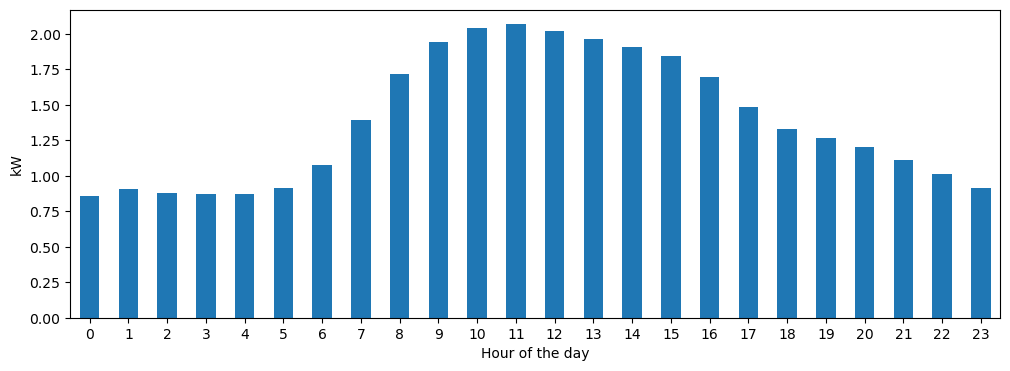

In [15]:
#Plot Distribution of load per hour of the day
fig, axs = plt.subplots(figsize=(12, 4))
df.groupby(df["Date and Time of capture"].dt.hour)["Parameter"].mean().plot(
    kind='bar', rot=0, ax=axs
)
plt.xlabel("Hour of the day");
plt.ylabel("kW");

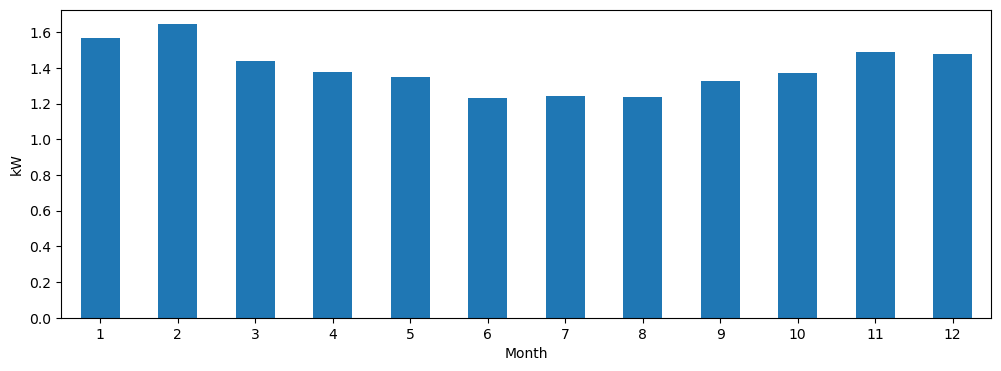

In [16]:
#Plot Distribution of load per month
fig, axs = plt.subplots(figsize=(12, 4))
df.groupby(df["Date and Time of capture"].dt.month)["Parameter"].mean().plot(
    kind='bar', rot=0, ax=axs
)
plt.xlabel("Month");
plt.ylabel("kW");

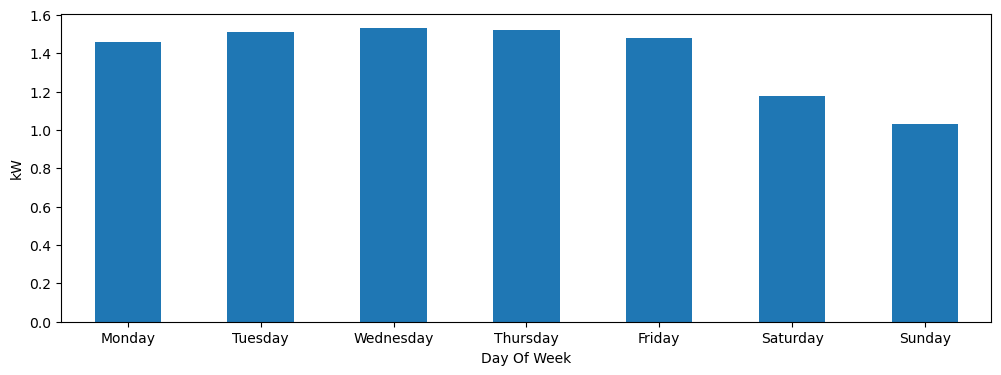

In [17]:
#Plot Distribution of load per day of the week
fig, axs = plt.subplots(figsize=(12, 4))
df.groupby(df["DayOfWeek"])["Parameter"].mean().plot(
    kind='bar', rot=0, ax=axs
)
plt.xlabel("Day Of Week");
plt.ylabel("kW");

### Multivariate Analysis

C:\Users\nanan\AppData\Local\Temp\ipykernel_6760\3954883840.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(),cbar=True,annot=True,cmap='Blues')


<Axes: >

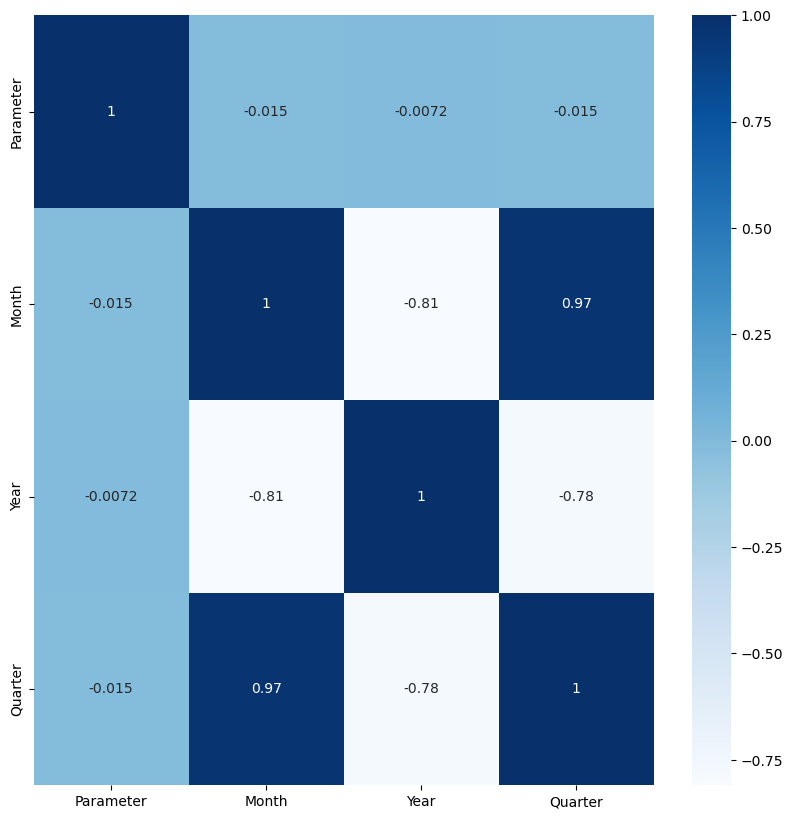

In [18]:
#Correlation heatmap
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(),cbar=True,annot=True,cmap='Blues')

Text(0, 0.5, 'Consumption')

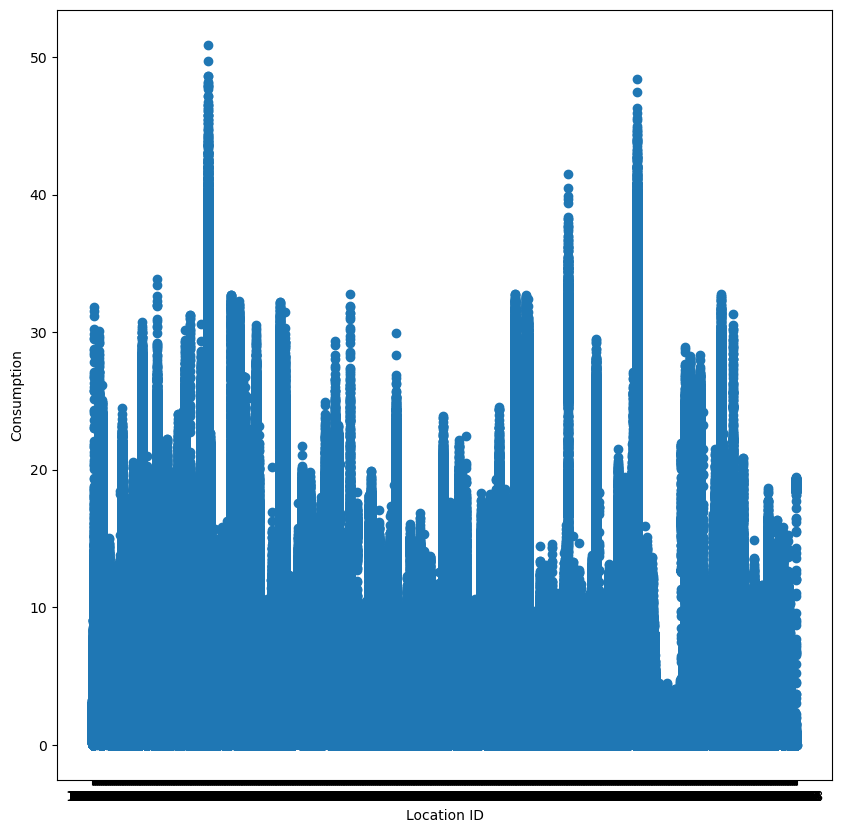

In [19]:
#Plot Load vs Location - How does location affect the consumption
plt.figure(figsize=(10,10))
plt.scatter(x='Location ID', y='Parameter', data=df)
plt.xlabel('Location ID')
plt.ylabel('Consumption')

In [20]:
#Data shape
mean = np.mean(df.Parameter)
std = np.std(df.Parameter)
skew = skew(df.Parameter)
ex_kurt = kurtosis(df.Parameter)
print("Skewness: {} \nKurtosis: {}".format(skew, ex_kurt+3))

Skewness: 4.605734932171133 
Kurtosis: 34.909412838751166


In [21]:
#Create function to group features
def features(df, label=None):
    X = df[['Hour','DayOfWeek','Quarter','Month','Year','Season']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = features(df, label='Parameter')
features = pd.concat([X, y], axis=1)

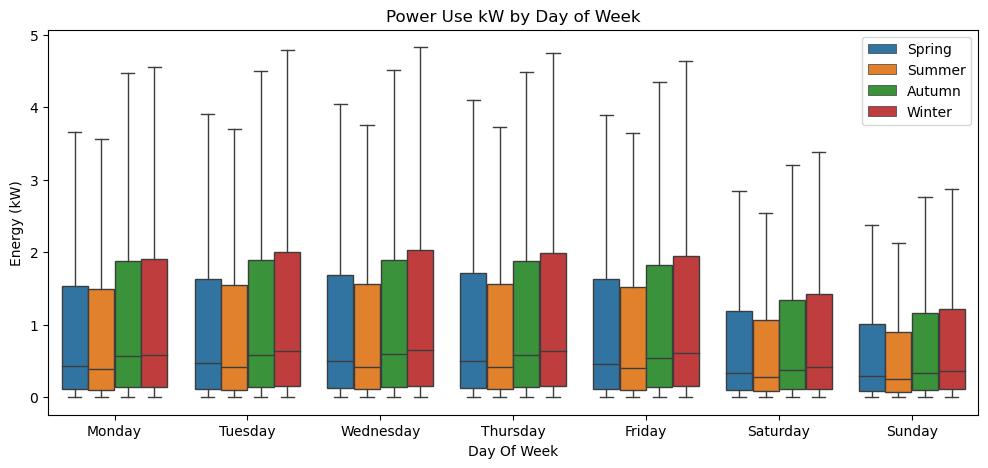

In [22]:
#Boxplot of Day of the Week and Season vs Load
fig, ax = plt.subplots(figsize=(12, 5))
sns.boxplot(data=features.dropna(),
            x='DayOfWeek',
            y='Parameter',
            hue='Season',
            ax=ax,
            linewidth=1,
           showfliers= False)
ax.set_title('Power Use kW by Day of Week')
ax.set_xlabel('Day Of Week')
ax.set_ylabel('Energy (kW)')
ax.legend(bbox_to_anchor=(1, 1))
plt.savefig('test.png', dpi=300)
plt.show()

In [23]:
#Dataframe after EDA
df.head()

,Location ID,Measurement Description,Parameter Type and Units,Date and Time of capture,Parameter,Date,Month,Year,Quarter,DayOfWeek,Hour,Season
0,100600,Electricity supply meter,Consumption in period [kWh],2012-03-01 00:00:00,0.893,2012-03-01 00:00:00,3,2012,1,Thursday,00:00:00,Winter
1,100600,Electricity supply meter,Consumption in period [kWh],2012-03-01 00:30:00,0.824,2012-03-01 00:30:00,3,2012,1,Thursday,00:30:00,Winter
2,100600,Electricity supply meter,Consumption in period [kWh],2012-03-01 01:00:00,0.795,2012-03-01 01:00:00,3,2012,1,Thursday,01:00:00,Winter
3,100600,Electricity supply meter,Consumption in period [kWh],2012-03-01 01:30:00,0.847,2012-03-01 01:30:00,3,2012,1,Thursday,01:30:00,Winter
4,100600,Electricity supply meter,Consumption in period [kWh],2012-03-01 02:00:00,0.730,2012-03-01 02:00:00,3,2012,1,Thursday,02:00:00,Winter


In [ ]:
df.to_csv("C:/Users/nanan/Masters/Nana/Dissertation/DataCleaning/EDA_Dataset.csv")
df.to_csv("C:/Users/nanan/EDA_Dataset.csv")